In [14]:
import numpy as np
import pandas as pd
import uproot
from pylorentz import Momentum4
import matplotlib.pyplot as plt
import scipy.stats as sps
from collections import Counter
%matplotlib inline
m_tau = 1.776

## create the profile plots

In [2]:
df_gen = pd.read_pickle('../shared/df_tt_gen_rho_rho.pkl')

In [3]:
df_gen.head()

,wt_cp_sm,wt_cp_ps,wt_cp_mm,rand,dm_1,dm_2,pi_E_1,pi_px_1,pi_py_1,pi_pz_1,...,pi0_py_2,pi0_pz_2,metx,mety,sv_x_1,sv_y_1,sv_z_1,sv_x_2,sv_y_2,sv_z_2
entry,,,,,,,,,,,,,,,,,,,,,
0,1.601494,0.310697,0.581832,0.529761,1.0,1.0,10.994950,8.404180,6.915075,1.555936,...,-3.580417,0.147664,21.212856,16.206368,0.023583,0.019393,0.005763,-0.581665,-0.513909,0.018126
1,1.616939,0.048255,0.718878,0.625262,10.0,0.0,80.198681,-3.553889,36.892234,-71.120615,...,0.000000,0.000000,4.612193,-13.801276,-0.097911,0.989190,-1.882611,0.000394,-0.001668,-0.005869
2,0.145634,1.555381,0.524301,0.600541,1.0,10.0,63.063316,33.907569,22.022118,48.396957,...,0.000000,0.000000,21.313398,48.146972,0.047770,0.031705,0.067133,-0.085217,0.345833,0.142905
3,1.487983,0.444336,1.316065,0.764755,1.0,1.0,29.041587,24.443190,-4.880136,-14.903323,...,-16.557451,-94.600909,6.099251,-8.346872,0.264949,-0.061602,-0.161944,-0.120283,-0.045656,-0.260196
4,0.370084,1.765682,1.648769,0.604970,10.0,10.0,5.500041,-4.350674,-2.053902,2.661596,...,0.000000,0.000000,-0.671295,1.881746,-0.304889,-0.132517,0.176034,0.196662,0.151155,0.536159


In [10]:
df_gen.columns

Index(['wt_cp_sm', 'wt_cp_ps', 'wt_cp_mm', 'rand', 'dm_1', 'dm_2', 'pi_E_1',
       'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_2', 'pi_px_2', 'pi_py_2',
       'pi_pz_2', 'pi0_E_1', 'pi0_px_1', 'pi0_py_1', 'pi0_pz_1', 'pi0_E_2',
       'pi0_px_2', 'pi0_py_2', 'pi0_pz_2', 'metx', 'mety', 'sv_x_1', 'sv_y_1',
       'sv_z_1', 'sv_x_2', 'sv_y_2', 'sv_z_2'],
      dtype='object')

In [4]:
def get_products(df_reco):
    pi_1 = Momentum4(df_reco['pi_E_1'], df_reco["pi_px_1"], df_reco["pi_py_1"], df_reco["pi_pz_1"])
    pi_2 = Momentum4(df_reco['pi_E_2'], df_reco["pi_px_2"], df_reco["pi_py_2"], df_reco["pi_pz_2"])
    pi0_1 = Momentum4(df_reco['pi0_E_1'], df_reco["pi0_px_1"], df_reco["pi0_py_1"], df_reco["pi0_pz_1"])
    pi0_2 = Momentum4(df_reco['pi0_E_2'], df_reco["pi0_px_2"], df_reco["pi0_py_2"], df_reco["pi0_pz_2"])
    rho_1 = pi_1 + pi0_1
    rho_2 = pi_2 + pi0_2
    return pi_1, pi_2, pi0_1, pi0_2, rho_1, rho_2

In [16]:
def profileplot(x, y, xlabel, ylabel, bins=100, mode=1):
    means_result = sps.binned_statistic(x, [y, y**2], bins=bins, statistic='mean')
    means, means2 = means_result.statistic
    standard_deviations = np.sqrt(means2 - means**2)
    bin_edges = means_result.bin_edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    # remove NaNs and single count bins
    nan_idx = np.argwhere(np.isnan(means) ).flatten()
    zero_idx = np.argwhere(standard_deviations == 0)
    to_remove = np.union1d(nan_idx, zero_idx)
    means = np.delete(means, to_remove, None)
    bin_centers = np.delete(bin_centers, to_remove, None)
    standard_deviations = np.delete(standard_deviations, to_remove, None)
    count = Counter(means_result.binnumber)
    to_remove_set = set(to_remove)
    N = []
    for i in range(1,bins+1):
        if i-1 in to_remove_set:
            continue
        if i in count:
            N.append(count[i])
#     print(to_remove.shape)
#     print(bin_centers.shape, means.shape)
    yerr = standard_deviations/np.sqrt(N)
#     yerr = standard_deviations
    # fitting
#     print(bin_centers, means, yerr)
    if mode == 1:
        fit, cov = np.polyfit(bin_centers, means, 1, w=1/yerr, cov=True)
        p = np.poly1d(fit)
        print(f"Fit params: {fit[0]}, {fit[1]}")
        print(f"Diag of cov: {cov[0][0]} , {cov[1][1]}")
    plt.figure()
    plt.errorbar(x=bin_centers, y=means, yerr=yerr, linestyle='none', marker='.', capsize=2)
    if mode == 1:
        plt.plot(bin_centers, p(bin_centers))
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    return fit, cov, bin_centers, means
plt.rcParams.update({'font.size': 14, "figure.figsize": (12,8)})

In [6]:
pi_1, pi_2, pi0_1, pi0_2, rho_1, rho_2 = get_products(df_gen)

Fit params: 0.004883525985161169, 0.2180749989957929
Diag of cov: 3.8589172618702905e-08 , 0.00019212727842735105


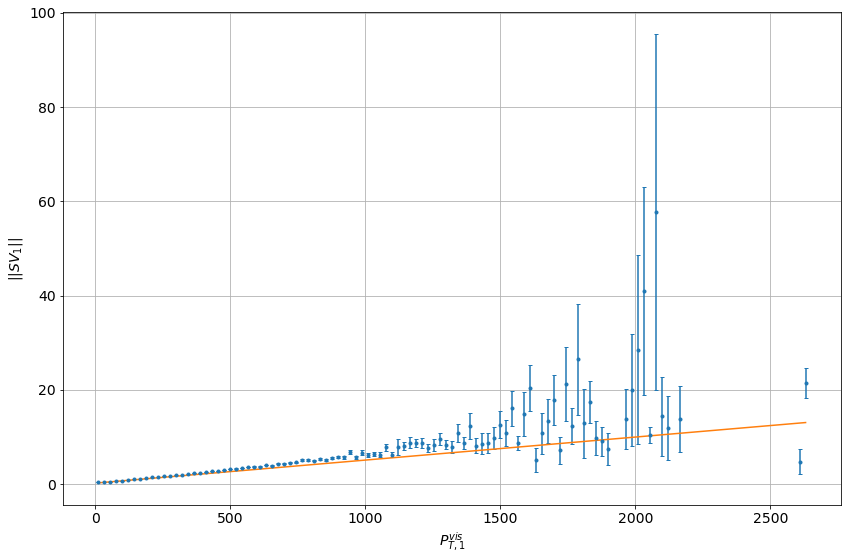

In [17]:
sv_1 = np.sqrt(df_gen['sv_x_1']**2 + df_gen['sv_y_1']**2 + df_gen['sv_z_1']**2)
_,_,x,y = profileplot(rho_1.p, sv_1, xlabel=r'$P_{T,1}^{vis}$', ylabel=r'$||SV_1||$', bins=150)

Fit params: 0.004378036068673947, 0.32596559737337905
Diag of cov: 4.022550918311424e-08 , 0.0001707743412664328


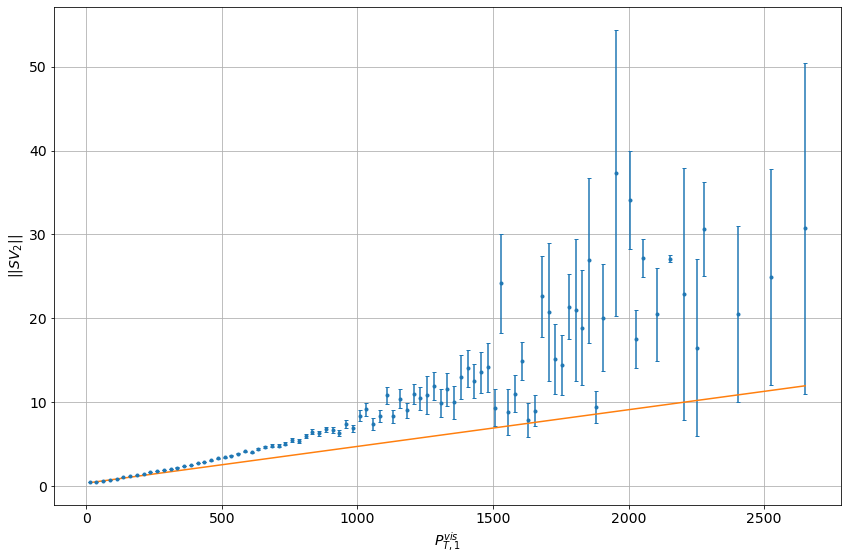

In [18]:
sv_2 = np.sqrt(df_gen['sv_x_2']**2 + df_gen['sv_y_2']**2 + df_gen['sv_z_2']**2)
_,_,x,y = profileplot(rho_2.p, sv_2, xlabel=r'$P_{T,1}^{vis}$', ylabel=r'$||SV_2||$', bins=150)